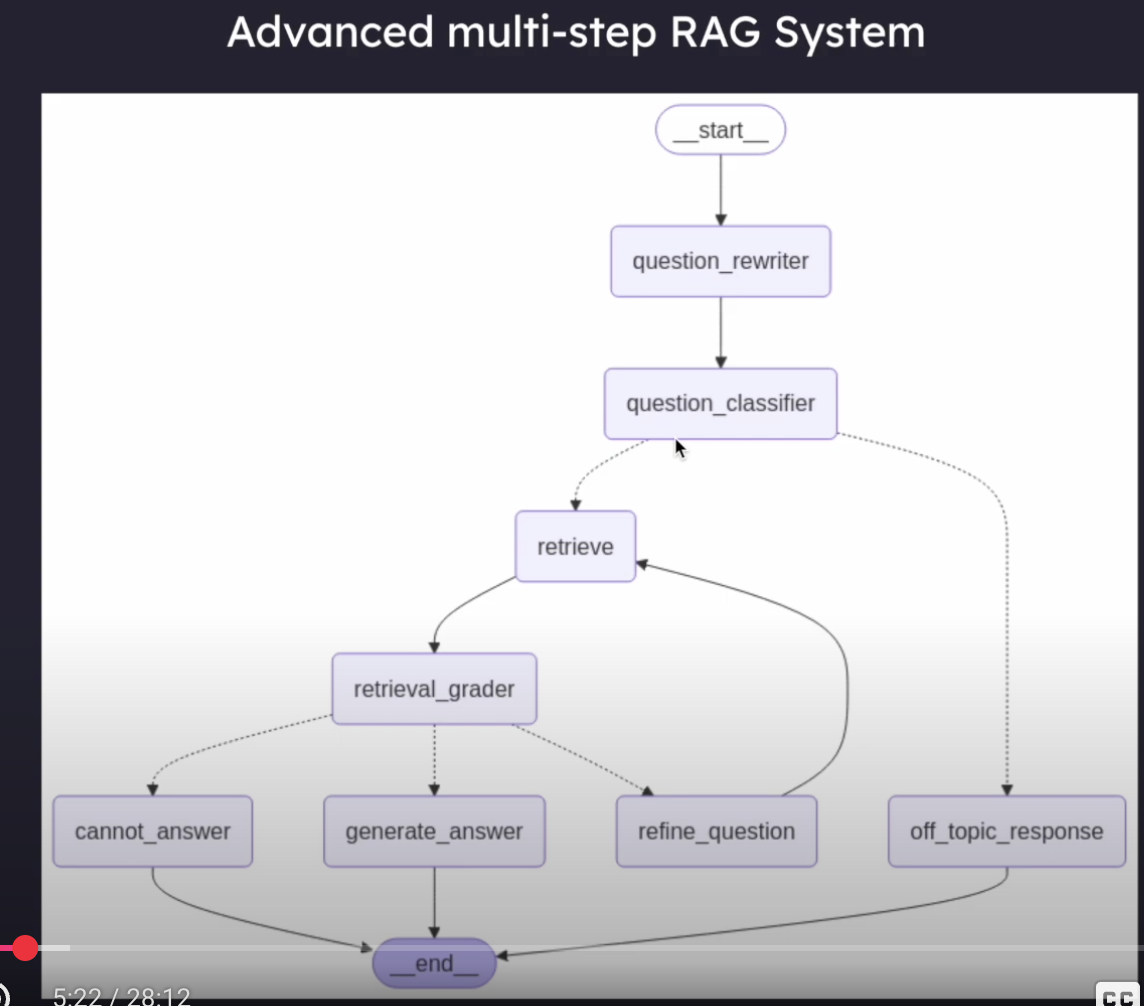

In [186]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI

from dotenv import load_dotenv
load_dotenv()

embedding_function = OpenAIEmbeddings()

In [187]:
docs = [
    Document(
        page_content="Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.",
        metadata={"source": "about.txt"}
    ),
    Document(
        page_content="Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.",
        metadata={"source": "hours.txt"}
    ),
    Document(
        page_content="Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes 24/7 access, personal training sessions, and spa facilities. We offer student and senior citizen discounts of 15% on all plans. Corporate partnerships are available for companies with 10+ employees joining.",
        metadata={"source": "membership.txt"}
    ),
    Document(
        page_content="Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and Wednesday at 6:00 PM. Intermediate and advanced classes are scheduled throughout the week. The full schedule is available on our mobile app or at the reception desk.",
        metadata={"source": "classes.txt"}
    ),
    Document(
        page_content="Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitness assessment and one free session with a trainer. Our head trainer, Neha Kapoor, specializes in rehabilitation fitness and sports-specific training. Personal training sessions can be booked individually (₹800/session) or in packages of 10 (₹7,000) or 20 (₹13,000).",
        metadata={"source": "trainers.txt"}
    ),
    Document(
        page_content="Peak Performance Gym's facilities include a cardio zone with 30+ machines, strength training area, functional fitness space, dedicated yoga studio, spin class room, swimming pool (25m), sauna and steam rooms, juice bar, and locker rooms with shower facilities. Our equipment is replaced or upgraded every 3 years to ensure members have access to the latest fitness technology.",
        metadata={"source": "facilities.txt"}
    )
]

db = Chroma.from_documents(docs, embedding_function)

In [188]:
retriever = db.as_retriever(search_type="mmr", search_kwargs={"k": 3})

In [189]:
# define state

from typing import TypedDict, List, Optional
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain.schema import Document

class AgentState(TypedDict):
    history: List[BaseMessage]
    documents: List[Document]  # Optional list of documents to be used by the agent
    on_topic: str  # The user's query or question
    rephrased_question : str  # The agent's response to the query
    proceed_to_generate: bool  # Additional context for the agent, if needed
    rephrase_count:int  # Metadata related to the conversation or documents
    original_question : HumanMessage

In [190]:
from langchain.prompts import ChatPromptTemplate

#define question rewriter function
def question_rewriter(state: AgentState):

    question = state["original_question"].content

    state["history"].append(state["original_question"])

    template = """You are a helpful assistant that rephrases the user's question to be a standalone question optimized for retrieval.
    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    llm = ChatOpenAI(model="gpt-4o-mini")
    chain = prompt | llm
    response = chain.invoke({"question": question})

    state["rephrased_question"] = response.content

     

    return state

In [191]:
from pydantic import BaseModel, Field
# define Question classifier function but its output is yes/no so we need structured output

#step 1: Define the schema for the question classifier grading
class question_classifier_grading_schema(BaseModel):
    score : str = Field(description = "Question is about specified topic ? If yes -> 'Yes', if no -> 'No'")


#step 2: Define the question classifier function
def question_classifier(state: AgentState):
    
    system_message = SystemMessage(
    content=""" You are a classifier that determines whether a user's question is about one of the following topics 
    
    1. Gym History & Founder
    2. Operating Hours
    3. Membership Plans 
    4. Fitness Classes
    5. Personal Trainers
    6. Facilities & Equipment
    7. Anything else about Peak Performance Gym
    
    If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.

    """
    )
    human_message = HumanMessage(
        content=f"User question: {state['rephrased_question']}"
    )
    grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0, max_tokens=50)

    structured_llm = llm.with_structured_output(question_classifier_grading_schema)

    grader_llm = grade_prompt | structured_llm
    response = grader_llm.invoke({})
    
    state["on_topic"] = response.score.strip()

    return state

In [192]:
def on_topic_router(state:AgentState):
    """
    Routes the state based on whether the question is on topic or not.
    If on topic, it proceeds to retrieve relevant documents.
    If not on topic, it sets proceed_to_generate to False.
    """
    if state["on_topic"] == "Yes":
        return "retrieve_documents"
    else:
        return "off_topic_response"

In [193]:
def retrieve_documents(state: AgentState):
    "retrieve documents based on the rephrased question"
    query = state["rephrased_question"]
    retrieved_docs = retriever.invoke(query)
    state["documents"] = retrieved_docs
    return state


In [194]:
def off_topic_response(state: AgentState):
    """
    Handles the case where the question is not on topic.
    Sets proceed_to_generate to False and provides a response.
    """
    print("The question is not on topic. No relevant documents found.")
    return state

In [195]:
# Need to Grade document if it is relevant to the question

#step1 : Define the schema for the document grading
class document_grading_schema(BaseModel):
    score: str = Field(description="Is the retrieved document relevant to the user's question? If yes -> 'Yes', if no -> 'No'")


def RetrieveDocumentsGrader(state: AgentState):
    """
    Retrieves documents based on the rephrased question.
    This function is called when the question is on topic.
    """

    print("Entering RetrieveDocumentsGrader function")

    template = """You are a grader assessing the relevance of a retrieved document to a user question.
    Only answer with 'Yes' or 'No'.
    If the document contains information relevant to the user's question, respond with 'Yes'.
    Otherwise, respond with 'No'.

    User Question: {question}
    Retrieved Document: {document}
    """
    prompt = ChatPromptTemplate.from_template(template)
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0, max_tokens=50)
    structured_llm = llm.with_structured_output(document_grading_schema)
    chain = prompt | structured_llm

    relevant_docs = []

    for doc in state["documents"]:
        response = chain.invoke({
            "question": state["rephrased_question"],
            "document": doc.page_content
        })

        print(f"Grading document: {doc.page_content[:30]}... Result: {response.score.strip()}")
        
        if response.score.strip() == "Yes":
            relevant_docs.append(doc)

    state["documents"] = relevant_docs
    state["proceed_to_generate"] = len(relevant_docs) > 0

    return state

In [196]:
# Proceed on to generate response if documents are relevant or display a message if no relevant documents found
def proceed_router(state: AgentState):
    """
    Routes the state based on whether there are relevant documents.
    If there are relevant documents, it proceeds to generate a response.
    If not, it sets proceed_to_generate to False.
    """
    if state["proceed_to_generate"]:
        return "generate_response"
    elif state["rephrase_count"] >= 2:
        return "cannot_answer"
    else:
        print("Routing to refine_question")
        return "refine_question"

In [197]:
def generate_response(state: AgentState):
    """
    Generates a response based on the retrieved documents and the rephrased question.
    This function is called when there are relevant documents.
    """
    template = """You are a helpful assistant that generates a response based on the user's question and the provided documents.
    User Question: {question}
    Retrieved Documents: {documents}
    
    Generate a concise and informative response based on the above documents.
    """
    
    prompt = ChatPromptTemplate.from_template(template)
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0, max_tokens=200)
    
    chain = prompt | llm
    response = chain.invoke({
        "question": state["rephrased_question"],
        "documents": "\n".join([doc.page_content for doc in state["documents"]]),
        "historty": state["history"]
    })

    state["history"].append(AIMessage(content=response.content.strip()))
    
    print(f"Generated response: {response.content}")
    
    return state

def cannot_answer(state: AgentState):
    """
    Handles the case where no relevant documents were found.
    Sets proceed_to_generate to False and provides a response.
    """
    print("No relevant documents found. Cannot generate a response.")
    state["proceed_to_generate"] = False
    state["history"].append(AIMessage(content="I'm sorry, I cannot answer that question. Please try rephrasing it."))
    return state

def refine_question(state: AgentState):
    """
    Handles the case where the question needs to be rephrased again.
    Increments the rephrase count and provides a response.
    """
    
    question = state["rephrased_question"]

    template = """You are a helpful assistant that slightly refines the user's question to improve retrieval results.
    Provide a slightly adjusted version of the question.
    
    Current Question: {question}

    """

    refine_prompt = ChatPromptTemplate.from_template(template)
    llm = ChatOpenAI(model="gpt-4o-mini")
    refine_chain = refine_prompt | llm
    response = refine_chain.invoke({"question": question})
    state["rephrased_question"] = response.content.strip()
    state["rephrase_count"] += 1
    print(f"Rephrasing question again. Current rephrase count: {state['rephrase_count']}")
    
    # Rephrase the question again
    return state

In [198]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

config={"configurable": {"thread_id": 1}}

In [199]:
from langgraph.graph import StateGraph, END

# Define the state graph
workflow = StateGraph(AgentState)
workflow.add_node("question_rewriter", question_rewriter)
workflow.add_node("question_classifier", question_classifier)
workflow.add_node("retrieve_documents", retrieve_documents)
workflow.add_node("RetrieveDocumentsGrader", RetrieveDocumentsGrader)
workflow.add_node("generate_response", generate_response)
workflow.add_node("cannot_answer", cannot_answer)
workflow.add_node("refine_question", refine_question)
workflow.add_node("off_topic_response", off_topic_response)

workflow.set_entry_point("question_rewriter")
workflow.add_edge("question_rewriter", "question_classifier")
workflow.add_conditional_edges("question_classifier", on_topic_router)

workflow.add_edge("retrieve_documents", "RetrieveDocumentsGrader")

workflow.add_conditional_edges("RetrieveDocumentsGrader", proceed_router)
workflow.add_edge("refine_question", "retrieve_documents")

workflow.add_edge("generate_response", END)
workflow.add_edge("cannot_answer", END)
workflow.add_edge("off_topic_response", END)

app = workflow.compile(checkpointer=checkpointer)
initial_state = AgentState(
    history = [],
    documents = [],
    on_topic = "" ,
    rephrased_question  = "",
    proceed_to_generate = False,
    rephrase_count = 0
)

# response = app.invoke(initial_state,config=config)
# print(response)

In [200]:
while True:
    user_input = input("Enter your question (or 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break

    initial_state["original_question"] = HumanMessage(content=user_input)
    response = app.invoke(initial_state, config=config)
    
    print("response:", response)
    # if response["proceed_to_generate"]:
    #     print("Response:", response["rephrased_question"])
    # else:
    #     print("No relevant documents found or unable to generate a response.")

Entering RetrieveDocumentsGrader function
Grading document: Peak Performance Gym was found... Result: Yes
Grading document: Peak Performance Gym was found... Result: Yes
Grading document: Group fitness classes at Peak ... Result: No
Generated response: The founder of Peak Performance Gym is Marcus Chen, a former Olympic athlete who established the gym in 2015.
response: {'history': [HumanMessage(content='who founded peak gym ?', additional_kwargs={}, response_metadata={}), AIMessage(content='The founder of Peak Performance Gym is Marcus Chen, a former Olympic athlete who established the gym in 2015.', additional_kwargs={}, response_metadata={})], 'documents': [Document(metadata={'source': 'about.txt'}, page_content='Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and fe

In [201]:
# template = """ You are a classifier that determines whether a user's question is about one of the following topics 
# 1. Gym History & Founder
# 2. Operating Hours
# 3. Membership Plans 
# 4. Fitness Classes
# 5. Personal Trainers
# 6. Facilities & Equipment
# 7. Anything else about Peak Performance Gym

# If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.
# User question: {question}

# """
# grade_prompt = ChatPromptTemplate.from_template(template)
# llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0, max_tokens=50)

# structured_llm = llm.with_structured_output(question_classifier_grading_schema)

# chain = grade_prompt | structured_llm

# question = "What is this ?"

# response = chain.invoke({"question": question})

# print(response.score.strip())  # Should print 'Yes' or 'No' based on the question's relevance to the topics
